# Maximum likelihood estimator for proportion estimation of different hominin species - denomstration

This notebook is a simple example of how the system is used to analyze a dataset

## Imports and loading data:

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
from ExplainableMaximumLikelihoodCalculator import ExplainableMaximumLikelihoodCalculator
import pysam
from Bio import SeqIO, Seq, SeqRecord, pairwise2
from Bio.pairwise2 import format_alignment
from LoadDataUtils import getListOfReadsFromBamFile, getListOfReadsFromFastaFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import shap
fileNameSapiens =  "data/simulatedData/human_chinese_AF346973_500samples.fas" #File that contains 500 reads from homo sapiens
fileNameNeanderthals =  "data/simulatedData/Neanderthal_Goyet_KX198085_500samples.fas" #File that contains 500 reads from neanderthal
fileNameDenisovans =  "data/simulatedData/denisova_kx663333_500samples.fas" #File that contains 500 reads from denisovan
neanderthals_500_generated = getListOfReadsFromFastaFile(fileNameNeanderthals)
sapiens_500_generated = getListOfReadsFromFastaFile(fileNameSapiens)
denisovan_500_samples = getListOfReadsFromFastaFile(fileNameDenisovans)
path_to_frequencies_table = "data/substitution_matrix.tsv"

2023-09-10 08:52:51.087380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 08:52:51.234184: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-10 08:52:51.265321: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-10 08:52:51.881647: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## We will now analyze a generated dataset of 50 reads from each species

In [2]:
number_of_sapienses = 50
number_of_neanderthals = 50
number_of_denisovans = 50

total_length = number_of_sapienses + number_of_neanderthals + number_of_denisovans
all_indexes = [i for i in range(total_length)]
neanderthal_indexes = [i for i in all_indexes if i<number_of_neanderthals]
sapienses_indexes = [i for i in all_indexes if i>= number_of_neanderthals and i < number_of_sapienses + number_of_neanderthals]
denisovans_indexes = [i for i in all_indexes if i>= number_of_sapienses + number_of_neanderthals]

dataset_1 = neanderthals_500_generated[:number_of_neanderthals] + sapiens_500_generated[:number_of_sapienses] + denisovan_500_samples[:number_of_denisovans]

### Load references file names for all species

In [3]:
sapiens_reference_file_names = [
                    "data/reference_files/human_AF346981_French.fa",
                     "data/reference_files/human_AY195760_Korea.fa",
                      "data/reference_files/human_AY882416_Ethiopia.fa",
                      "data/reference_files/human_AY963586_Italian.fa",
                      "data/reference_files/human_AY195781_Caucasian.fa",
                      "data/reference_files/human_AY195757_Iraqi-Israeli.fa",
                      "data/reference_files/human_AY195749_NativeAmerican.fa"]
neanderthals_reference_file_names = [
                            "data/reference_files/neanderthal_mezmaiskaya1_FM865411.fa",
                           "data/reference_files/Neanderthal_Altai_KC879692.fa",
                           "data/reference_files/Neanderthal_Denisova11_full_mtDNA_KU131206.fa",
                           "data/reference_files/Neanderthal_Spy_94a_MG025538.fa",
                            "data/reference_files/Neanderthal_Vindija33.16_AM948965.fa",
                            "data/reference_files/Neanderthal_Vindija33.19_KJ533545.fa"]
denisovan_reference_file_names = [  
                        "data/reference_files/Denisova_MT576653.1.fa",
                        "data/reference_files/Denisova_MT576652.1.fa",
                        "data/reference_files/Denisova_4_FR695060.fa",
                        "data/reference_files/Denisova_8_KT780370.fa",
                        "data/reference_files/Denisova_manual_phalanx_NC_013993.fa",
                        "data/reference_files/Denisova_MT576651.1.fa"]

### Creating a maximum likelihood estimator - to estimate the contribution of each species to the data set:

In [4]:
maximum_likelihood_calculator_d_1 = ExplainableMaximumLikelihoodCalculator(dataset_1,
                                                ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                ref_sapien_file_names=sapiens_reference_file_names,
                                                ref_denisovan_file_names=denisovan_reference_file_names,
                                                path_to_substitution_matrix=path_to_frequencies_table,
                                                number_of_jobs=-1)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  150
start working on read number 0
start working on read number 40
start working on read number 80
start working on read number 120


### Estimation to the contribution of each species to the data set:
#### This compares the ground truth to the output of the system.

In [5]:
total_number_of_reads = maximum_likelihood_calculator_d_1.number_of_reads
estimation = maximum_likelihood_calculator_d_1.estimate_species_proportions(100)
actual_values = {'Homo Sapiens' : number_of_sapienses / total_number_of_reads, 'Neanderthals' : number_of_neanderthals / total_number_of_reads, 'Denisovans':number_of_denisovans / total_number_of_reads}
comparison = estimation.append(actual_values, ignore_index=True).rename(index={0: "Estimation", 1: "Actual"})
comparison


,Homo Sapiens,Neanderthals,Denisovans
Estimation,0.340000,0.330000,0.330000
Actual,0.333333,0.333333,0.333333


As you can see above, the system correctly estimated that the proportions in the dataset are ($1 \over 3$, $1 \over 3$, $1 \over 3$).


### We will start with the explanations - we now estimate the shapley values for every sequence using SHAP:

In [6]:
shapleys = maximum_likelihood_calculator_d_1.calculate_shapley_values(nsamples=5000)

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000


#### Raw values of the shapley estimation, on every species

Text(0, 0.5, 'Influence value')

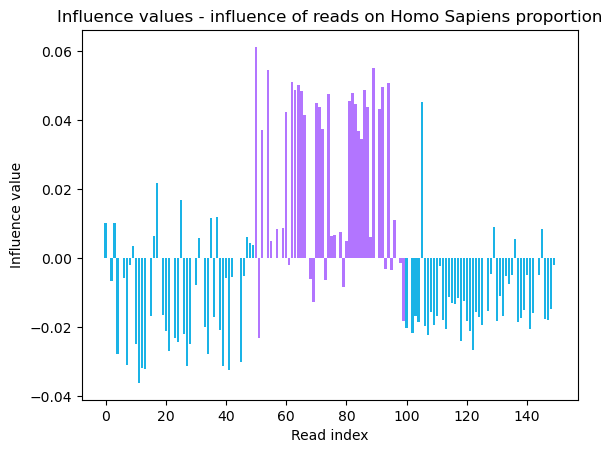

In [12]:
color = [(0.1,0.7,0.9)]*50 + [(0.5,0.1,1,0.6)]*50+[(0.1,0.7,0.9)]*50
plt.bar([i for i in range(150)],shapleys[0][0],color=color)
plt.title("Influence values - influence of reads on Homo Sapiens proportion")
plt.xlabel("Read index")
plt.ylabel("Influence value")


Text(0, 0.5, 'Influence value')

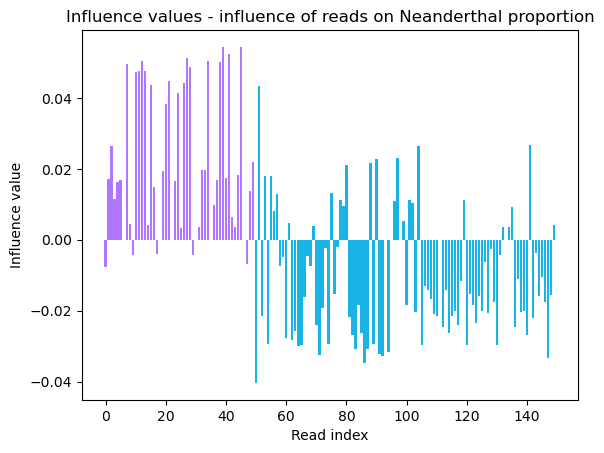

In [13]:
color = [(0.5, 0.1, 1, 0.6)]*50 + [(0.1,0.7,0.9)]*100
plt.bar([i for i in range(150)],shapleys[1][0],  color=color)
plt.title("Influence values - influence of reads on Neanderthal proportion")
plt.xlabel("Read index")
plt.ylabel("Influence value")


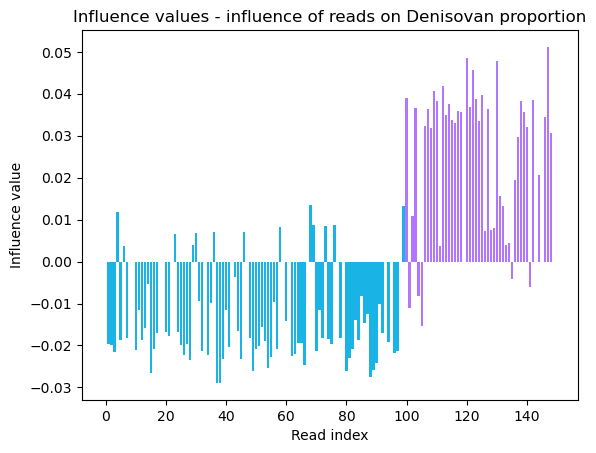

In [14]:
color = [(0.1,0.7,0.9)]*100+[(0.5,0.1,1,0.6)]*50
plt.bar([i for i in range(150)],shapleys[2][0],color=color)
plt.title("Influence values - influence of reads on Denisovan proportion")
plt.xlabel("Read index")
plt.ylabel("Influence value")
plt.show()


## Generate counter factual

In [15]:
cf = maximum_likelihood_calculator_d_1.generateCounterFactualMinimalSetToRemoveAndChangeMax(shapleys)

Change dominating species from Homo Sapiens to Neanderthal would require removing 1 reads: [50]
